In [1]:
%load_ext autotime

In [2]:
import os
from glob import glob

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('bmh')

from tqdm import tqdm_notebook

from piaa.utils import pipeline
from piaa.utils.postgres import get_cursor
from piaa.utils import helpers
from pocs.utils.images import fits as fits_utils
from pocs.utils.images import crop_data

from piaa.utils.postgres import get_cursor
tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

time: 2.26 s


In [3]:
fields_dir = os.path.join(os.environ['PANDIR'], 'images', 'fields')

time: 989 µs


In [4]:
# base_dir = os.path.join(fields_dir, 'PAN001/Hd189733/14d3bd/20180913T085704')
# base_dir = os.path.join(fields_dir, 'PAN001/Hd189733/ee04d1/20180913T085704')
base_dir = os.path.join(fields_dir, 'PAN012/Hd189733/358d0f/20180822T035809')
# base_dir = os.path.join(fields_dir, 'PAN001/Wasp50/ee04d1/20181215T050712')

base_dir

'/var/panoptes/images/fields/PAN012/Hd189733/358d0f/20180822T035809'

time: 5.77 ms


In [5]:
# Get all the files that start with a time stamp (skip pointing files)
fits_files = sorted(glob(
    os.path.join(base_dir, '*2018*.fits')
), )
print("Found {} FITS files".format(len(fits_files)))

Found 128 FITS files
time: 4.9 ms


## Lookup point sources

Looking up the point sources invovles two steps, extracting detected sources from the image and matching those with a catalog.

> Note: This assumes the images have already been downloaded and plate-solved.  
> _todo(wtgee) add a link to a notebook that does that_

**Source Detection** For source extraction there are three methods available but the default is to use the well-known [`sextractor`](https://www.astromatic.net/software/sextractor) to  automatically detect sources according to certain configurable parameters. The [PIAA sextractor config](https://raw.githubusercontent.com/panoptes/PIAA/develop/resources/conf_files/sextractor/panoptes.sex) sets a photometric aperture of 6 pixels ($6 \times 10.3'' \approx 80''$) and a detection threshold of 1.5 sigmas. Further filtering of flags and basic SNR is done below.

**Catalog Matching** PANOPTES hosts a copy of the TESS Input Catalog (v6) against which the detected sources are matched. The detection uses the peak pixel value as reported by `sextractor` compared against the TICv6 using standard [astropy catalog matching](http://docs.astropy.org/en/stable/coordinates/matchsep.html#matching-catalogs) techniques. Reported catalog separation is neglible, especially regarding the creationg of the stamps for the RGB pixel pattern (see below).

In [6]:
# Lookup the point sources
point_sources = pipeline.lookup_point_sources(
    fits_files[0], 
    force_new=True,
    cursor=tess_cursor,
)

# Display example
display(point_sources.head())
print(f'Sources extracted: {len(point_sources)}')

,ra,dec,x,y,x_image,y_image,background,flux_best,fluxerr_best,mag_best,...,flux_aper,fluxerr_aper,mag_aper,magerr_aper,flux_max,fwhm_image,flags,tmag,vmag,catalog_sep_arcsec
picid,,,,,,,,,,,,,,,,,,,,,
10777186,297.767960,27.716880,448,2142,447.7061,2142.1719,3231.971,30788.46,2257.431,13.7790,...,22732.92,1577.937,14.1084,0.0754,3076.094,6.95,0,7.628,7.58872,5.655294
10883789,297.755282,26.813254,766,2149,766.2598,2148.8264,3299.973,13486.62,1649.770,14.6752,...,13376.79,1575.959,14.6841,0.1279,2455.175,4.56,0,7.077,8.14900,7.799772
11027938,297.727150,24.627367,1533,2164,1533.3717,2164.3020,3357.790,57670.23,2569.349,13.0976,...,42759.13,1582.162,13.4224,0.0402,6737.298,3.76,0,7.442,7.43070,5.443080
11036706,297.869000,24.322085,1640,2120,1640.6381,2120.0442,3208.968,23133.84,2236.825,14.0894,...,15624.50,1577.544,14.5155,0.1096,2586.156,2.02,0,7.629,8.67000,5.190274
11133818,297.903248,26.226025,973,2104,973.2496,2104.0847,3332.072,52708.25,3299.416,13.1953,...,36888.30,1583.137,13.5828,0.0466,4101.782,5.93,0,7.542,7.48000,5.941396


Sources extracted: 1034
time: 7.13 s


#### Lookup all files

Perform the same thing again but for all files. The resulting source catalog created from `sextractor` is saved for each image and reused in subsequent runs unless `force_new=True`.

Extract the observation time, the exposure time, and the airmass from the FITS headers.

The image observation time currently comes from the image file name, which is generated by the computer running the unit and is given in UTC. This is mainly due to a problem with the `DATE-OBS` header in the FITS files for POCS versions <0.6.2.

In [6]:
source_filename = os.path.join(base_dir, f'point-sources-detected.csv')

observation_sources = pipeline.lookup_sources_for_observation(
    fits_files=fits_files, 
    filename=source_filename, 
    cursor=tess_cursor, 
    force_new=True,
)

100%|██████████| 128/128 [14:12<00:00,  6.57s/it]


time: 14min 17s


In [8]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 128 Sources: 1765
time: 15.2 ms


## Filter detected sources

The above sequence does basic source filtering via `sextractor` along with what can be matched in the TESS catalog. Below are a number of different ways to filter the frames and/or sources based on image quality, number of detections, etc.

The filtering for the `PAN012` HD189733 data set involves the steps below. At the bottom of the notebook are optional filter methods.

#### Image filtering

We can do some quick checks on the overall image sequence. here we look at the mean background as detected by `sextractor`. It's a rough metric but we can clearly see some frames where the background levels spike, indicating clouds in the region.

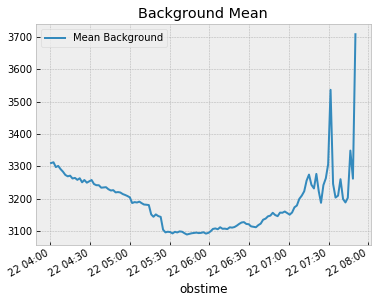

time: 393 ms


In [9]:
plt.figure(figsize=(6, 4.5))
observation_sources.groupby('obstime').background.mean().plot(label='Mean Background')
plt.title(f'Background Mean')
plt.legend()

#### Filter frames by number of detected sources

Here we remove frames where the total number of detected frames is outside of two standard deviations of the mean number of detected sources.

Usually this is due to clouds passing over, which causes the number of detected sources to drop dramatically across the entire frame.

We could have a smarter method of filtering these frames, e.g. by examining the FWHM of the stars.

In [10]:
num_sources = observation_sources.groupby('obstime').count().file
min_sources = int(num_sources.mean() - (2 * num_sources.std()))
print(f'Frames should have at least {min_sources} sources')

Frames should have at least 918 sources
time: 27.6 ms


In [11]:
observation_sources.groupby('obstime').describe().head()

ra                                                \
                          count        mean       std         min         25%   
obstime                                                                         
2018-08-22 04:00:29.450  1034.0  299.340832  2.940860  293.745618  296.973601   
2018-08-22 04:02:19.450  1058.0  299.280167  2.920410  293.745432  296.961634   
2018-08-22 04:04:05.450  1039.0  299.395404  2.948416  293.745355  297.080368   
2018-08-22 04:05:52.450  1041.0  299.298817  2.949848  293.745212  296.951624   
2018-08-22 04:07:40.450  1051.0  299.313215  2.948792  293.745102  296.958228   

                                                                dec  \
                                50%         75%         max   count   
obstime                                                               
2018-08-22 04:00:29.450  299.525546  301.887549  304.391749  1034.0   
2018-08-22 04:02:19.450  299.406000  301.809056  304.391711  1058.0   
2018-08-22 04:04:05.450  299.577290  301.991318  304.392196  1039.0   
2018-08-22 04:05:52.450  299.436197  301.920125  304.391905  1041.0   
2018-08-22 04:07:40.450  299.466647  301.920374  304.391669  1051.0   

                                       ...        airmass             picid  \
                              mean     ...            75%       max   count   
obstime                                ...                                    
2018-08-22 04:00:29.450  21.550758     ...       1.122710  1.122710  1034.0   
2018-08-22 04:02:19.450  21.541715     ...       1.119109  1.119109  1058.0   
2018-08-22 04:04:05.450  21.569570     ...       1.115741  1.115741  1039.0   
2018-08-22 04:05:52.450  21.608874     ...       1.112385  1.112385  1041.0   
2018-08-22 04:07:40.450  21.530654     ...       1.109075  1.109075  1051.0   

                                                                               \
                                 mean           std         min           25%   
obstime                                                                         
2018-08-22 04:00:29.450  2.905121e+08  1.137838e+08  10777186.0  2.444575e+08   
2018-08-22 04:02:19.450  2.923074e+08  1.118515e+08  10777186.0  2.445298e+08   
2018-08-22 04:04:05.450  2.911388e+08  1.125843e+08  10777186.0  2.444842e+08   
2018-08-22 04:05:52.450  2.918317e+08  1.129694e+08  10777186.0  2.444902e+08   
2018-08-22 04:07:40.450  2.910457e+08  1.130458e+08  10777186.0  2.445097e+08   

                                                                 
                                 50%           75%          max  
obstime                                                          
2018-08-22 04:00:29.450  300777184.0  3.881973e+08  471012056.0  
2018-08-22 04:02:19.450  300995485.5  3.881160e+08  471012056.0  
2018-08-22 04:04:05.450  300778570.0  3.881081e+08  471012056.0  
2018-08-22 04:05:52.450  301063568.0  3.882189e+08  471012056.0  
2018-08-22 04:07:40.450  300779168.0  3.880220e+08  471012056.0  

[5 rows x 192 columns]

time: 8.2 s


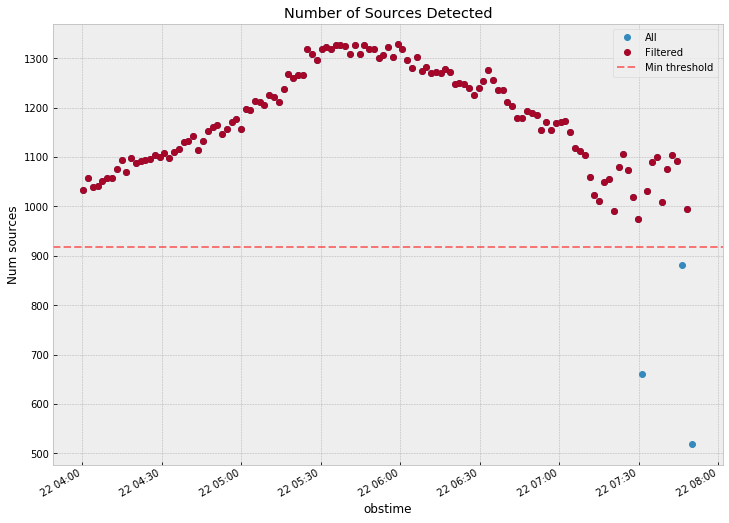

time: 822 ms


In [12]:
plt.figure(figsize=(12, 9))
observation_sources.groupby('obstime').count().picid.plot(marker='o', ls='', label='All')
observation_sources.groupby('obstime').filter(
    lambda grp: grp.count().picid >= min_sources
).groupby('obstime').count().file.plot(marker='o', ls='', label='Filtered')
plt.axhline(min_sources, c='r', alpha=0.5, ls='--', label='Min threshold')

plt.ylabel('Num sources')
plt.title('Number of Sources Detected')
plt.legend()

In [13]:
# Filter out the frames where the number of source detections is outside the std
observation_sources = observation_sources.groupby('obstime').filter(lambda grp: grp.count()['file'] >= min_sources)

time: 294 ms


In [14]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 125 Sources: 1764
time: 15.4 ms


#### Filter sources by number of frames

Now that we have removed frames where there were a low number of detections (presumably from clouds) we now want to remove sources that don't appear in most of the frames.

In [15]:
frame_count = observation_sources.groupby('picid').count().file
min_frame_count = int(frame_count.max() * .9)

print(f'Total frames: {frame_count.max()} Min cutout: {min_frame_count}')

Total frames: 125 Min cutout: 112
time: 36.6 ms


Text(0.5, 1.0, 'Total number of frames')

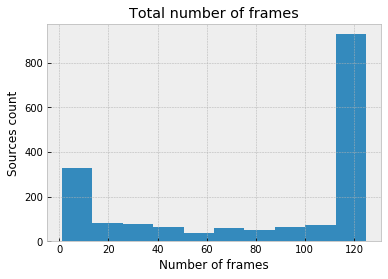

time: 368 ms


In [16]:
# Show a sample of the source count
frame_count.hist()
plt.xlabel('Number of frames')
plt.ylabel('Sources count')
plt.title('Total number of frames')

In [17]:
# Filter out the sources where the number of frames is less than min_frame_count
observation_sources = observation_sources.groupby('picid').filter(lambda grp: grp.count()['file'] >= min_frame_count)

time: 2.21 s


In [18]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 125 Sources: 933
time: 11.7 ms


#### Filter frames by manual time-clipping

For now we are going to simply manually remove the frames after a certain time that was visually identified with cloud cover.

In [ ]:
observation_sources = observation_sources.loc[observation_sources.index.levels[1] < '2018-08-22 07:10:00']

#### Filter frames by Sigma-clip

We can sigma clip the frames based on the mean background value, removing any frame that deviate wildly from the rest of the sequence.

In [ ]:
back_mean, back_median, back_std = sigma_clipped_stats(image_group.background.mean())

observation_sources = observation_sources.groupby('obs_time').filter(lambda grp: np.abs(grp['background'].mean() - back_mean) <= 3 * back_std )

num_frames = len(observation_sources.index.unique())

In [ ]:
num_frames = len(observation_sources.index.levels[1].unique())
num_sources = len(observation_sources.index.levels[0].unique())
print(f"Frames: {num_frames} Sources: {num_sources}")

In [ ]:
plt.figure(figsize=(6, 4.5))
plt.plot(observation_sources.groupby('obs_time').background.mean().values, label='Mean Background')
plt.title(f'Background Mean')
plt.legend()

#### Source filtering

`sextractor` does basic thresholding and source detection per frame but here we filter sources based off the entire image sequence. The simplest filter is to get all the images with a certain SNR limit (default 10). A filter for source extractor flags can also be used.

> Note: There has been a manual selection of images (see above) for overall data quality. Some kind of image quality check (e.g. drifting zeropoint) could help automate this

In [19]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 125 Sources: 933
time: 11 ms


#### sextractor flags filter

Filter out anything with [SE flags](http://matilda.physics.ucdavis.edu/working/website/SEflags.html) of 4 or more. Note that this is leaving in some blended sources 

In [20]:
observation_sources = observation_sources.groupby('picid').filter(lambda grp: all(grp['flags'] < 4))

time: 507 ms


In [21]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 125 Sources: 818
time: 10.4 ms


##### SNR Filter

The SNR comes directly from `sextractor` in the form of `FLUX_AUTO / FLUXERR_AUTO`.

In [22]:
snr_limit = 10

high_snr = lambda grp: (grp['flux_best'] / grp['fluxerr_best']).mean() > snr_limit

observation_sources = observation_sources.groupby('picid').filter(high_snr)

time: 551 ms


In [23]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 125 Sources: 334
time: 4.93 ms


#### FWHM Filter

We also want to get rid of the stars where `sextractor` reports a large FWHM. This could be refined but for now we do a simple cut.

In [24]:
fwhm_limit = 5

low_fwhm = lambda grp: (grp['fwhm_image']).mean() <= fwhm_limit

observation_sources = observation_sources.groupby('picid').filter(low_fwhm)

time: 155 ms


In [25]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 125 Sources: 186
time: 3.84 ms


#### Output filtered source detections

We save this filtered file to be used for subsequent processing.

In [26]:
filtered_filename = os.path.join(base_dir, f'point-sources-filtered.csv.bz2')

time: 743 µs


In [29]:
observation_sources.to_csv(filtered_filename, compression='bz2')

time: 1.48 s


In [30]:
ls -lh $filtered_filename

-rw-r--r-- 1 wtylergee wtylergee 1.5M Dec 20 20:37 /var/panoptes/images/fields/PAN012/Hd189733/358d0f/20180822T035809/point-sources-filtered.csv.bz2
time: 134 ms
